In [1]:
"""
Decision Tree
"""

'\nDecision Tree\n'

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
X_train =np.array([[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,1,1,0],[0,0,0,0],[1,0,0,0],[1,0,0,1],[1,1,1,1],[1,0,1,2],[1,0,1,2],[2,0,1,2],
         [2,0,1,1],[2,1,0,1],[2,1,0,2],[2,0,0,1]],dtype='float')
y_train =np.array([[0],[0],[1],[1],[0],[0],[0],[1],[1],[1],[1],[1],[1],[1],[0]],dtype='float')
print('X_train shape ',X_train.shape)

print(X_train)
print('y_train shape ',y_train.shape)
print(y_train)

data =np.concatenate([X_train,y_train],axis=1)
print('data shape ',data.shape)
features_names =['age','job','house','credit']
category_names =['reject','recept']

X_train shape  (15, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 2.]
 [1. 0. 1. 2.]
 [2. 0. 1. 2.]
 [2. 0. 1. 1.]
 [2. 1. 0. 1.]
 [2. 1. 0. 2.]
 [2. 0. 0. 1.]]
y_train shape  (15, 1)
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]
data shape  (15, 5)


In [2]:
def entropy(y):
    n =len(y)
    labels =np.unique(y)
    res =0
    for i in range(len(labels)):
        counts =np.count_nonzero(y==labels[i])
        res =res +((counts/n))*np.log2(((counts/n)))
    return -1*res

def info_gain(X,y,k):
    [n,p]=X.shape
    H1 =entropy(y)
    items =np.unique(X[:,k])
    res =0
    for i in range(len(items)):
        index = (X[:,k]==items[i])
        data =y[index]
        res = res +(len(data)/n)*entropy(data)
    return entropy(y)-res
def info_gain_ratio(X,y,k):
    return (info_gain(X,y,k)/entropy(X[:,k]))
def gini(y):
    n =len(y)
    labels =np.unique(y)
    res =0
    for i in range(len(labels)):
        counts =np.count_nonzero(y==labels[i])
        res =res + (counts*counts)/(n*n)
    return 1-res
    

In [29]:
class Node(object):
    
    def __init__(self,data=None,father=None,child=None,entr=None,label=None,mask=None,name=None):
        self.data=data
        self.father=father
        self.child=child
        self.entr=entr
        self.label=label
        self.mask =mask
        self.name =name

class ID3(object):

    def __init__(self,head=None,leaves=[],features=None,category=None):
        self.head =head
        self.leaves =leaves
        self.features =features
        self.category =category
    
    def build_tree(self,father,data,eps):
        root =Node(data=data)
        root.father =father
        [n,p]=data.shape
        p =p-1
        labels =np.unique(data[:,-1])
        root.entr =entropy(data[:,-1])
        mask =np.ones((p+1,),dtype='bool')
        root.mask =mask
        root.child=[]
        feature_gain =0
        index =0
        temp =0
        for i in range(p):
            temp =info_gain(data[:,0:-1],data[:,-1],i)
            if(feature_gain<temp):
                feature_gain=temp
                index =i
             
        if(p==0 or (feature_gain!=0 and feature_gain<=eps)):
            counts =0
            label=0
            for i in range(len(labels)):
                if(counts>np.count_nonzero(data[:,]==labels[i])):
                    counts =np.count_nonzero(data[:,]==labels[i])
                    label =labels[i]
            root.label =label
            self.leaves.append(root)
            return root
        if(len(labels)==1):
            root.label=labels[0]
            self.leaves.append(root)
            return root
        features =np.unique(data[:,index])
        mask[index]=0
        root.mask=mask
        for i in range(len(features)):
            data_child =data[(data[:,index]==features[i]),:]
            child =self.build_tree(root,data_child[:,mask],eps)
            root.child.append(child)
        return root
    
    def pruning(self,alpha =0.2):
        leaves =self.leaves
        stop =0
        i =0
        while(i<len(leaves)):
            if(len(leaves)==1):
                break
            cur =leaves[i]
            father =cur.father
            res =alpha*(len(father.child)-1)-father.entr*(len(father.data[:,-1]))
            for son in father.child:
                res =res + son.entr*(len(son.data[:,-1]))
            print('delta loss between father and son ',res)
            if(res<=0):
                i =i+1
            else:
                labels =np.unique(father.data[:,-1])
                counts =0
                for i in range(len(labels)):
                    if(counts<np.count_nonzero(father.data[:,-1]==labels[i])):
                        counts =np.count_nonzero(father.data[:,-1]==labels[i])
                        father.label =labels[i]
                print('pruning')
                print('self.leaves \n ',self.leaves)
                print('father child \n ',father.child)
                for child in father.child:
                    self.leaves.remove(child)
                father.child=[]
                mask =~father.mask
                index =np.where(mask==True)[0][0]
                father.mask[index]=True
                self.leaves.insert(0,father)
                leaves =self.leaves
                i=0
                
    def predict(self,root,X):
        print('node ',root)
        if(root.child==[] or root.label!=None):
            return root.label
        print('X ',X)
        print('root.data ',root.data)
        mask =~(root.mask)
        feature =X[mask[:-1]]
        print('root.mask ',root.mask)
        labels =np.unique(root.data[:,mask])
        print('feature ',feature)
        print('labels ',labels)
        index =np.where(labels==feature)[0][0]
        print('index ',index)
        print('mask.shape ',mask.shape)
        return self.predict(root.child[index],X[root.mask[:-1]])
        
        
        
                        
                
            
            
            
        
    
   
        

            
                
            
                
        

In [30]:
head =Node()
tree =ID3()
tree.head =tree.build_tree(None,data,0.02)
for leave in tree.leaves:
    print(leave.data)
    print('****************************')

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [2. 1. 0.]]
****************************
[[0. 1. 1.]
 [2. 1. 1.]
 [2. 2. 1.]]
****************************
[[0. 1. 0. 1.]
 [1. 1. 1. 1.]
 [1. 0. 2. 1.]
 [1. 0. 2. 1.]
 [2. 0. 2. 1.]
 [2. 0. 1. 1.]]
****************************


In [41]:
tree.pruning(alpha=10)
print(tree.leaves)

delta loss between father and son  1.7353374935095935
pruning
self.leaves 
  [<__main__.Node object at 0x7f50295eec50>, <__main__.Node object at 0x7f50295ee940>, <__main__.Node object at 0x7f50295eea58>]
father child 
  [<__main__.Node object at 0x7f50295eec50>, <__main__.Node object at 0x7f50295ee940>]
delta loss between father and son  3.700403589670378
pruning
self.leaves 
  [<__main__.Node object at 0x7f504423d048>, <__main__.Node object at 0x7f50295eea58>]
father child 
  [<__main__.Node object at 0x7f504423d048>, <__main__.Node object at 0x7f50295eea58>]


In [44]:
print('label ',tree.leaves[len(tree.leaves)-1].label)
print('mask ',tree.leaves[len(tree.leaves)-1].mask)
print('child ',tree.leaves[len(tree.leaves)-1].child)
print(tree.leaves[len(tree.leaves)-1].child==None)

label  1.0
mask  [ True  True  True  True  True]
child  []
False


In [45]:
test =np.array([0,1],dtype='bool')
np.where(test==0)[0]

array([0])

In [46]:
X_test =np.array([2,0,0,0],dtype='float')
tree.predict(tree.head,X_test)


node  <__main__.Node object at 0x7f502969af98>


1.0

In [48]:
from sklearn.datasets import make_blobs

In [54]:
X,y =make_blobs(n_samples=40,centers=2,random_state=6)


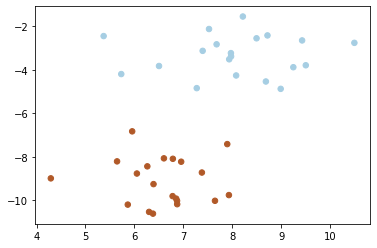

In [50]:

plt.scatter(X[:,0],X[:,1],c=y,s=30,cmap=plt.cm.Paired)


In [158]:
X,y =make_blobs(n_samples=40,centers=2,random_state=6)

y =y[:,np.newaxis]
print(X.shape)
print(y.shape)
new_data =np.concatenate([X,y],axis=1)
newhead =Node()
new_tree =ID3()
new_tree.head =new_tree.build_tree(None,new_data,0.02)

(40, 2)
(40, 1)


In [161]:
X_train =np.random.uniform(-4,4,size=(20,2))+np.random.rand(20,2)*0.5
y_train =0.5*(X_train[:,0]*X_train[:,0])+0.5*(X_train[:,1]*X_train[:,1])+1
y_train =y_train[:,np.newaxis]

X_train  (20, 2)
y_train  (20, 1)
data
[[-0.22665435 -0.11050465  1.03179174]
 [ 0.68256711 -1.63287742  2.56609327]
 [-1.93161291  2.61704897  6.29003686]
 [-3.68389061 -1.91860902  9.62605532]
 [ 1.18389602 -0.97636301  2.17744725]
 [ 3.22110927  3.08427105 10.9441364 ]
 [-2.72914601  0.36571648  4.79099324]
 [ 1.88313704  0.82308053  3.11183334]
 [ 1.16456088  1.08570135  2.26747473]
 [ 1.71202326 -2.01382745  4.49326232]
 [ 3.50697583 -2.79538342 11.056524  ]
 [-1.29107556 -3.69730992  8.66848837]
 [ 3.37017763 -2.52645238  9.87052944]
 [ 2.3128392   3.70331086 10.53186823]
 [ 1.11238542 -2.31479762  4.29784467]
 [-3.47000823 -1.92527252  8.87381571]
 [-1.5566589   3.3506763   7.8251093 ]
 [-1.05764151 -1.45645809  2.61993787]
 [-1.2590852   3.3414335   7.37523669]
 [ 2.16068221 -0.76240716  3.62490614]]


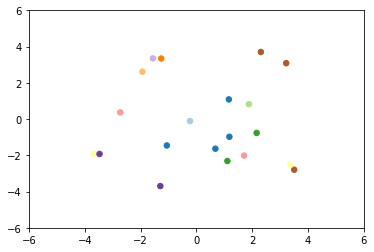

In [206]:
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)
data =np.concatenate([X_train,y_train],axis=1)
plt.xlim(-6,6)
plt.ylim(-6,6)
plt.scatter(data[:,0],data[:,1],c=data[:,2],s=30,cmap=plt.cm.Paired)
print('data')
print(data)

In [213]:
class CartNode(object):
    def __init__(self,data=None,right=None,left=None,father=None,conditions=None,index=None,val=None,loss=None,ave=None):
        self.data =data
        self.right =right
        self.left  =left
        self.father =father
        self.conditions =conditions  #(p,2) array [low,high)
        self.index =index            #
        self.val =val
        self.loss =loss
        self.ave =ave                #weight

def belong(X,conditions,index):
    [n,p]=X.shape
    res =np.ones((n,1),dtype='bool')
    for i in range(p):
        res =res & (conditions[i][0]<=X[:,i] &conditions[i][1]>X[:,i] )
    return res
        

class CartTree(object):
    def __init__(self,head=None,limits=None,blocks=None,weights=None,iterations=None,times=None):
        self.head =None
        self.limits =None
        self.blocks =None
        self.weights =None
        self.iterations =iterations
        self.times =times
    
    def build_tree(self,father,data,conditions,loss,ave,eps):
        [n,p]=data.shape
        root =CartNode(data=data,father=father,conditions=conditions)
        root.ave =ave
        root.loss =loss
        #print('loss ',loss)
        #print('ave  ',ave)
        #print('n ',n)
        #print('p ',p)
        if(self.times>=self.iterations):
            return root;
        if(n==0):
            return root
        
        p =p-1
        index =0
        val =0
        err =999999
        for i in range(p):
            line =np.linspace(conditions[i,0],conditions[i,1],num=100)
            for j in range(len(line)):
                s =line[j]
                mask = (data[:,i]<s)
                y_left =data[mask,-1]
                y_right =data[~mask,-1]
                mean_left =np.mean(y_left)
                mean_right =np.mean(y_right)
                loss_left =np.sum(np.square(mean_left -y_left))
                loss_right =np.sum(np.square(mean_right-y_right))
                if(err>(loss_left +loss_right)):
                    err =loss_left +loss_right
                    index =i
                    val =s
                    #print('in loop')
                    #print('err ',err)
                    #print('index ',index)
                    #print('val ',val)


        mask =(data[:,index]<val)
        data_left =data[mask,:]
        data_right =data[~mask,:]
        mean_left =np.mean(data_left[:,-1])
        mean_right =np.mean(data_right[:,-1])
        loss_left =np.sum(np.square(mean_left -data_left[:,-1]))
        loss_right =np.sum(np.square(mean_right -data_right[:,-1]))
        
        #print('index ',index)
        #print('val   ',val)
        #print('data_left ',data_left)
        #print('data_right ',data_right)
        
        #print('err ',err)
        #print('loss ',loss)
        if(np.abs(err-loss)<=eps):
            return root;
        
        root.index =index
        root.val =val
        temp =conditions[index][1]
        conditions[index][1]=val
        root.left =self.build_tree(father=root,data=data_left,conditions=conditions,loss=loss_left,ave=mean_left,eps=eps)
        
        conditions[index][1]=temp
        temp =conditions[index][0]
        conditions[index][0]=val
        root.right =self.build_tree(father=root,data=data_right,conditions=conditions,loss=loss_right,ave=mean_right,eps=eps)      
        conditions[index][0]=temp
        self.times =self.times+1
        return root
    
    
    def preorder(self,root):
        if(root==None):
            return
        self.preorder(root.left)
        print('index  ',root.index)
        print('val    ',root.val)
        print('ave    ',root.ave)
        self.preorder(root.right)
    
    def predict(self,root,X):
        if(root.index==None):
            return root.ave
        index =root.index
        val   =root.val
        if(X[index]<val):
            return self.predict(root.left,X)
        else:
            return self.predict(root.right,X)
        
    
        
    
    
    
        

In [214]:
carthead =CartNode()
carttree =CartTree(head=carthead,iterations=10000,times=0)
conditions =np.zeros((X_train.shape[1],2),dtype='float')
conditions[:,0] =np.min(X_train,axis=0)-1
conditions[:,1] =np.max(X_train,axis=0)+1
print(conditions)


[[-4.68389061  4.50697583]
 [-4.69730992  4.70331086]]


In [215]:
loss =np.sum(np.square(data[:,-1]-np.mean(data[:,-1])))

carttree.head=carttree.build_tree(father=carthead,data=data,conditions=conditions,loss=loss,ave=np.mean(data[:,-1]),eps=0.01)


In [216]:
carttree.head.father=None

In [217]:
carttree.preorder(root=carttree.head)

index   None
val     None
ave     9.626055315127612
index   0
val     -3.667523525606838
ave     9.056119795945532
index   None
val     None
ave     8.873815706744518
index   0
val     -3.469277071490615
ave     8.77115203635449
index   None
val     None
ave     8.668488365964464
index   1
val     -1.8486369554362998
ave     7.635676496421995
index   None
val     None
ave     4.790993236565246
index   0
val     -2.726206880079988
ave     5.540515050154409
index   None
val     None
ave     6.2900368637435715
index   0
val     -1.915166475829512
ave     6.570344021779345
index   None
val     None
ave     7.825109298429187
index   0
val     -1.5540747201178204
ave     7.60017299340428
index   None
val     None
ave     7.375236688379374
index   0
val     -1.2142236559185813
ave     4.977520424962885
index   None
val     None
ave     4.2978446664308905
index   0
val     1.1213178200246388
ave     4.395553494396318
index   None
val     None
ave     4.493262322361746
index   1
val     -1.9435

In [221]:
X_test =np.array([-1.3,3.4],dtype='float')
carttree.predict(carttree.head,X_test)

7.375236688379374

In [398]:
class CartClassifyNode(object):
    def __init__(self,data=None,left=None,right=None,father=None,index=None,val=None,loss=None,label=None):
        self.data=data
        self.left=left
        self.right=right
        self.father=father
        self.index=index
        self.val=val
        self.loss=loss
        self.label=label


    
    
class CartClassifyTree(object):
    
    def __init__(self,head=None,leaves=None,alpha=None,models=None):
        self.head=head
        self.leaves=[]
        self.alpha=[]
        self.models=[]
    
    def build_tree(self,father,data,loss,eps):
        root=CartClassifyNode(data=data,father=father,loss=loss)
        [n,p]=data.shape
        p =p-1
        labels =np.unique(data[:,-1])
        label =0
        counts=0
        for i in range(len(labels)):
            if(counts<(np.count_nonzero(labels==labels[i]))):
                label =labels[i]
                counts =np.count_nonzero(labels==labels[i])
        if(loss<eps):
            root.label =label
            self.leaves.append(root)
            return root
        ginis =9999
        index =0
        val =0
        feature_same =1
        for i in range(p):
            features =np.unique(data[:,i])
            if(len(features)>1):
                feature_same=0
            for j in range(len(features)):
                mask =(data[:,i]==features[j])
                data_left =data[mask,:]
                data_right =data[~mask,:]
                gini_left =gini(data_left[:,-1])
                gini_right =gini(data_right[:,-1])
                gini_total =len(data_left[:,-1])*gini_left+len(data_right[:,-1])*gini_right
                if(ginis>gini_total):
                    ginis =gini_total
                    index =i
                    val =features[j]
        if(feature_same==1):
            root.label=label
            self.leaves.append(root)
            return root
        root.index=index
        root.val=val
        mask =(data[:,index]==val)
        data_left =data[mask,:]
        data_right =data[~mask,:]
        gini_left =gini(data_left[:,-1])
        gini_right =gini(data_right[:,-1])
        root.left =self.build_tree(father=root,data=data_left,loss=gini_left*len(data_left[:,-1]),eps=eps)
        root.right=self.build_tree(father=root,data=data_right,loss=gini_right*len(data_right[:,-1]),eps=eps)
        return root
        
    def preorder(self,root):
        if(root==None):
            return [0,0]
        if(root.label!=None):
            #print('Node ',root)
            #print('index ',root.index)
            #print('val ',root.val)
            #print('loss ',root.loss)
            #print('label ',root.label)
            #print('data')
            #print(root.data)
            
            return [1,root.loss]
        l =0
        [l1,res1] =self.preorder(root.left)
        [l2,res2] =self.preorder(root.right)
        #print('Node ',root)
        #print('index ',root.index)
        #print('val ',root.val)
        #print('loss ',root.loss)
        #print('label ',root.label)
        #print('data')
        #print(root.data)
        l =l1+l2
        res =res1+res2
        return [l,res]
    
    def inorder(self,root):
        if(root==None):
            return
        self.inorder(root.left)
        print('Node ',root)
        print('index ',root.index)
        print('val ',root.val)
        print('loss ',root.loss)
        print('label ',root.label)
        print('data')
        print(root.data)
        self.inorder(root.right)
        return
        
    
    def predict(self,root,X):
        if(root.label!=None):
            return root.label
        index =root.index
        val =root.val
        if(X[index]==val):
            return self.predict(root.left,X)
        else:
            return self.predict(root.right,X)
    
    def copytree(self,source):
        if(source==None) :
            return None
        target =CartClassifyNode()
        target.data=source.data
        target.left=source.left
        target.right=source.right
        target.father=source.father
        target.index=source.index
        target.val=source.val
        target.loss=source.loss
        target.label=source.label
        target.left =self.copytree(source.left)
        target.right=self.copytree(source.right)
        return target
        

    def validation(self,head,data):
        #print(data)
        [n,p] =data.shape
        
        predicts =np.zeros((n,),dtype='float')
       
        for i in range(n):
            predicts[i]=self.predict(head,data[i,:-1])
        print('predicts ',predicts)
        return np.sum(predicts!=data[:,-1])
    
    def minGiniNode(self,root):
        min_g_score =666
        if(root==None):
            return [None,999]
        if(root.label!=None):
            return [root,777]
        cur =root
        [l,res] =self.preorder(root)
        [left,left_score] =self.minGiniNode(root.left)
        [right,right_score]=self.minGiniNode(root.right)
        
        print("**************************************")
        print('l ',l)
        print('res ',res)
        score =(root.loss - res)/(l-1)
        print('score ',score)

        print('left_score ',left_score)
        print('right_score ',right_score)
        min_node =root
        min_g_score =score
        if(min_g_score>left_score ):
            min_g_score =left_score
            min_node=left
        if(min_g_score>right_score ):
            min_g_score=right_score
            min_node=right
        return [min_node,min_g_score]
    
    def delete_child(self,root):
        if(root==None):
            return
        if(root.label!=None):
            print('delete child ',root)
            self.leaves.remove(root)
            return
        self.delete_child(root.left)
        self.delete_child(root.right)
       
    def pruning(self,data):
        
        last =0
        g_score =999
        node =None
        self.alpha.append(0)
        self.models.append(self.copytree(self.head))
        print('len(self.leaves) ',len(self.leaves))
        while(len(self.leaves)>2):
            
            if(len(self.leaves)==2):
                break
            last =g_score
            [node,gscore]=self.minGiniNode(self.head)
            print('current leaves size ',len(self.leaves))
            print('current gscore ',gscore)
            print('current node   ',node)
            if(last==gscore):
                break
            #if(node==self.head):
            #    break
            labels =np.unique(node.data[:,-1])
            counts =0
            val =0
            for i in range(len(labels)):
                if(counts<np.count_nonzero(labels==labels[i])):
                    counts =np.count_nonzero(labels==labels[i])
                    val =labels[i]
            self.delete_child(root=node)
            node.label=val
            node.left=None
            node.right=None
            node.index=None
            node.val=None
            self.leaves.insert(0,node)
            self.alpha.append(gscore)
            self.models.append(self.copytree(self.head))

        
        #print models and hypoparameter
        best_model=None
        best_alpha =0
        best_score =9999
        temp =0
        for i in range(len(self.models)):
            print('models : \n',self.inorder(self.models[i]))
            print('alpha  : ',self.alpha[i])
            temp =self.validation(self.models[i],data)
            print('validation score: ',temp)
   
            
            if(best_score>temp):
                best_score=temp
                best_alpha =self.alpha[i]
                best_model =self.models[i]
        return [best_score,best_alpha,best_model]
                
            
        
        
            
            
                    
            
            
            
            
        
    
    
                        

In [399]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
X_train =np.array([[1,0,0,0],[0,1,0,2],[0,1,0,0],[0,1,1,0],[2,0,0,1],[1,0,1,1],[1,0,1,2],[1,0,1,2],[2,0,1,2],
         [2,0,1,1],[2,1,1,1],[2,0,1,1]],dtype='float')
y_train =np.array([[1],[0],[0],[1],[0],[1],[1],[0],[1],[0],[1],[0]],dtype='float')
print('X_train shape ',X_train.shape)

print(X_train)
print('y_train shape ',y_train.shape)
print(y_train)

data =np.concatenate([X_train,y_train],axis=1)
print('data shape ',data.shape)
features_names =['age','job','house','credit']
category_names =['reject','recept']







newCartNode =CartClassifyNode()
newCartTree =CartClassifyTree(head=newCartNode)
loss =gini(data[:,-1])*len(data[:,-1])
newCartTree.head=newCartTree.build_tree(father=newCartNode,data=data,loss=loss,eps=0.05)
newCartTree.head.father=None

X_train shape  (12, 4)
[[1. 0. 0. 0.]
 [0. 1. 0. 2.]
 [0. 1. 0. 0.]
 [0. 1. 1. 0.]
 [2. 0. 0. 1.]
 [1. 0. 1. 1.]
 [1. 0. 1. 2.]
 [1. 0. 1. 2.]
 [2. 0. 1. 2.]
 [2. 0. 1. 1.]
 [2. 1. 1. 1.]
 [2. 0. 1. 1.]]
y_train shape  (12, 1)
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
data shape  (12, 5)


In [400]:
newCartTree.preorder(root=newCartTree.head)

[6, 1.0]

In [401]:
X_test =np.array([2,1,0,2],dtype='float')
print('X_test shape ',X_test.shape)
newCartTree.predict(newCartTree.head,X_test)

X_test shape  (4,)


0.0

In [402]:
newCartTree.preorder(root=newCartTree.copytree(source=newCartTree.head))

[6, 1.0]

In [403]:
print(data.shape)
test_data =np.array([[1,1,0,2,0],[0,1,0,1,1],[1,0,1,2,1],[0,1,0,1,1],[1,1,1,0,0],[0,1,0,0,1],[1,0,0,2,0],[2,1,0,2,0]],dtype='float')
print('predict error: ',newCartTree.validation(head=newCartTree.head,data=test_data))

(12, 5)
predicts  [0. 0. 0. 0. 1. 0. 0. 0.]
predict error:  5


In [404]:
[best_score,best_alpha,best_model]=newCartTree.pruning(data=test_data)
print('best score ',best_score)
print('best alpha ',best_alpha)
print('best_model ',best_model)

len(self.leaves)  6
**************************************
l  2
res  1.0
score  0.5
left_score  777
right_score  777
**************************************
l  2
res  0.0
score  1.3333333333333333
left_score  777
right_score  777
**************************************
l  3
res  0.0
score  1.2
left_score  1.3333333333333333
right_score  777
**************************************
l  4
res  0.0
score  1.25
left_score  777
right_score  1.2
**************************************
l  6
res  1.0
score  1.0
left_score  0.5
right_score  1.2
current leaves size  6
current gscore  0.5
current node    <__main__.CartClassifyNode object at 0x7f10386f2f60>
delete child  <__main__.CartClassifyNode object at 0x7f10386f2978>
delete child  <__main__.CartClassifyNode object at 0x7f10386f29e8>
**************************************
l  2
res  0.0
score  1.3333333333333333
left_score  777
right_score  777
**************************************
l  3
res  0.0
score  1.2
left_score  1.3333333333333333
right_score

In [405]:
newCartTree.inorder(newCartTree.head)

Node  <__main__.CartClassifyNode object at 0x7f1039109b00>
index  None
val  None
loss  6.0
label  0.0
data
[[1. 0. 0. 0. 1.]
 [0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1.]
 [2. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]
 [2. 0. 1. 2. 1.]
 [2. 0. 1. 1. 0.]
 [2. 1. 1. 1. 1.]
 [2. 0. 1. 1. 0.]]


In [406]:
print(newCartTree.models)

[<__main__.CartClassifyNode object at 0x7f10386f11d0>, <__main__.CartClassifyNode object at 0x7f1039b64a90>, <__main__.CartClassifyNode object at 0x7f10386f7278>]


In [407]:
newCartTree.inorder(newCartTree.models[0])

Node  <__main__.CartClassifyNode object at 0x7f10386f1828>
index  None
val  None
loss  1.0
label  0.0
data
[[1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f10386f1198>
index  3
val  2.0
loss  1.5
label  None
data
[[1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f10386f16a0>
index  None
val  None
loss  0.0
label  1.0
data
[[1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1.]]
Node  <__main__.CartClassifyNode object at 0x7f10386f11d0>
index  0
val  1.0
loss  6.0
label  None
data
[[1. 0. 0. 0. 1.]
 [0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1.]
 [2. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]
 [2. 0. 1. 2. 1.]
 [2. 0. 1. 1. 0.]
 [2. 1. 1. 1. 1.]
 [2. 0. 1. 1. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f10386f1400>
index  None
val  None
loss  0.0
label  0.0
data
[[0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [2. 0. 0. 1. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f10386

In [396]:
newCartTree.inorder(newCartTree.models[1])

Node  <__main__.CartClassifyNode object at 0x7f1039b73e10>
index  None
val  None
loss  1.5
label  0.0
data
[[1. 0. 0. 0. 1.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f1039b73c50>
index  0
val  1.0
loss  6.0
label  None
data
[[1. 0. 0. 0. 1.]
 [0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1.]
 [2. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]
 [2. 0. 1. 2. 1.]
 [2. 0. 1. 1. 0.]
 [2. 1. 1. 1. 1.]
 [2. 0. 1. 1. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f1039b739b0>
index  None
val  None
loss  0.0
label  0.0
data
[[0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [2. 0. 0. 1. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f1039b737b8>
index  2
val  0.0
loss  3.75
label  None
data
[[0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1.]
 [2. 0. 0. 1. 0.]
 [2. 0. 1. 2. 1.]
 [2. 0. 1. 1. 0.]
 [2. 1. 1. 1. 1.]
 [2. 0. 1. 1. 0.]]
Node  <__main__.CartClassifyNode object at 0x7f1039b731d0>
index  None
val  None
loss  

In [397]:
newCartTree.inorder(newCartTree.models[2])

Node  <__main__.CartClassifyNode object at 0x7f1039b73080>
index  None
val  None
loss  6.0
label  0.0
data
[[1. 0. 0. 0. 1.]
 [0. 1. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1.]
 [2. 0. 0. 1. 0.]
 [1. 0. 1. 1. 1.]
 [1. 0. 1. 2. 1.]
 [1. 0. 1. 2. 0.]
 [2. 0. 1. 2. 1.]
 [2. 0. 1. 1. 0.]
 [2. 1. 1. 1. 1.]
 [2. 0. 1. 1. 0.]]
